## Import Necessary Packages

In [1]:
# !pip install pyspark

In [2]:
import os
os.environ['PYSPARK_PYTHON'] = 'python'

In [3]:
def show(df,count = None,n=5):
    if count =="y":
        leng = df.count()
        col_len = len(df.columns)
        print(f"shape:({leng},{col_len})")
    df = df.limit(n)
    dfs = df.toPandas()
    return dfs

In [4]:
import numpy as np
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum,mean
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when
from tabulate import tabulate
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('customersatisfaction').getOrCreate()

In [6]:
spark

## Read datasets

In [7]:
train_data_path = 'train.csv'
df = spark.read.csv(train_data_path,inferSchema=True,header = True)
test_data_path = "test.csv"
test_df = spark.read.csv(test_data_path,inferSchema = True,header = True)

In [8]:
show(df)

,_c0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [9]:
show(test_df)

,_c0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [10]:
print("Total train data rows :",df.count())
print("total train data columns: ",len(df.columns))
print("Total test data rows:",test_df.count())
print("Total test data columns:",len(test_df.columns))

Total train data rows : 103904
total train data columns:  25
Total test data rows: 25976
Total test data columns: 25


## Data pre-processing

### drop unnecessary columns

In [11]:
# Drop unnecessary columns
df = df.drop('_c0', 'id')

# Check size of the data set
df.printSchema()
print(f"Number of records: {df.count()}")

root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer 

In [12]:
# Drop unnecessary columns
test_df = test_df.drop('_c0', 'id')

# Check size of the data set
test_df.printSchema()
print(f"Number of records: {test_df.count()}")

root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Departure Delay in Minutes: integer 

### Replacing label column "satisfaction" values with 0 and 1 (neutral or dissatisfied = 0 and satisfied = 1) - Train and Test

In [13]:
value_counts_df = df.groupBy('satisfaction').count()
#to_pandas()
value_counts_df.show()

+--------------------+-----+
|        satisfaction|count|
+--------------------+-----+
|neutral or dissat...|58879|
|           satisfied|45025|
+--------------------+-----+



In [14]:
# Transform 'satisfaction' column in df
df = df.withColumn('satisfaction', 
                   when(df['satisfaction'] == 'neutral or dissatisfied', 0)
                   .when(df['satisfaction'] == 'satisfied', 1))

# Transform 'satisfaction' column in test_df
test_df = test_df.withColumn('satisfaction', 
                             when(test_df['satisfaction'] == 'neutral or dissatisfied', 0)
                             .when(test_df['satisfaction'] == 'satisfied', 1))

### Check for the nature of dataset - balanced or imbalanced

In [15]:
df.groupBy('satisfaction').count().show()

+------------+-----+
|satisfaction|count|
+------------+-----+
|           1|45025|
|           0|58879|
+------------+-----+



### Handling missing value

In [16]:
from tabulate import tabulate
from pyspark.sql.functions import col

def display_null_counts(df, dataset_type):
    null_counts = {}
    for col_name in df.columns:
        null_count = df.filter(col(col_name).isNull()).count()
        null_counts[col_name] = null_count

    # Prepare data for tabulate
    table = []
    for col_name, null_count in null_counts.items():
        table.append([col_name + f'_{dataset_type}', null_count])
    
    return tabulate(table, headers=['Column', 'Null Count'], tablefmt='pretty')



In [17]:
train_null_counts = display_null_counts(df, 'train')
test_null_counts = display_null_counts(test_df, 'test')



In [18]:
print("Total null values in train dataset:\n", train_null_counts)


Total null values in train dataset:
 +-----------------------------------------+------------+
|                 Column                  | Null Count |
+-----------------------------------------+------------+
|              Gender_train               |     0      |
|           Customer Type_train           |     0      |
|                Age_train                |     0      |
|          Type of Travel_train           |     0      |
|               Class_train               |     0      |
|          Flight Distance_train          |     0      |
|       Inflight wifi service_train       |     0      |
| Departure/Arrival time convenient_train |     0      |
|      Ease of Online booking_train       |     0      |
|           Gate location_train           |     0      |
|          Food and drink_train           |     0      |
|          Online boarding_train          |     0      |
|           Seat comfort_train            |     0      |
|      Inflight entertainment_train       |     0  

In [19]:
print("Total null values in test dataset:\n", test_null_counts)

Total null values in test dataset:
 +----------------------------------------+------------+
|                 Column                 | Null Count |
+----------------------------------------+------------+
|              Gender_test               |     0      |
|           Customer Type_test           |     0      |
|                Age_test                |     0      |
|          Type of Travel_test           |     0      |
|               Class_test               |     0      |
|          Flight Distance_test          |     0      |
|       Inflight wifi service_test       |     0      |
| Departure/Arrival time convenient_test |     0      |
|      Ease of Online booking_test       |     0      |
|           Gate location_test           |     0      |
|          Food and drink_test           |     0      |
|          Online boarding_test          |     0      |
|           Seat comfort_test            |     0      |
|      Inflight entertainment_test       |     0      |
|         On

### Handling the missing data

In [20]:
train_mean = df.agg(F.mean('Arrival Delay in Minutes')).collect()[0][0]
test_mean = test_df.agg(F.mean('Arrival Delay in Minutes')).collect()[0][0]
# Fill missing values  with the calculated mean
train_df = df.na.fill({'Arrival Delay in Minutes':train_mean})
test_df = test_df.na.fill({'Arrival Delay in Minutes':test_mean})

In [21]:
train_df.count()

103904

In [22]:
test_df.count()

25976

## EDA

This is done by tableau

In [23]:
show(train_df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [24]:
train_df1 = train_df.toPandas()
train_df1.to_csv("airline_customer_satisfaction.csv",index = False)

In [25]:
# train_df1.columns

<Axes: xlabel='Inflight service', ylabel='satisfaction'>

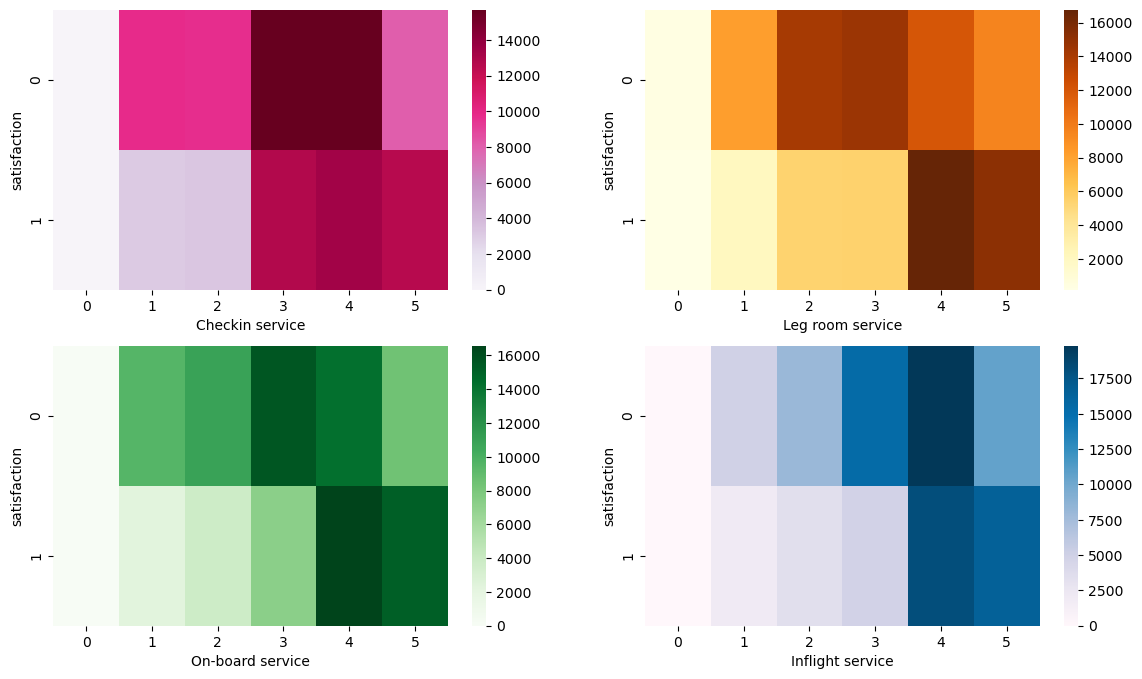

In [26]:
# Checkin_service, Leg_room_service, On-board_service and Inflight_service

fig, axarr = plt.subplots(2, 2, figsize=(14, 8))

table1 = pd.crosstab(train_df1['satisfaction'], train_df1['Checkin service'])
sns.heatmap(table1, cmap='PuRd', ax = axarr[0][0])
table2 = pd.crosstab(train_df1['satisfaction'], train_df1['Leg room service'])
sns.heatmap(table2, cmap='YlOrBr', ax = axarr[0][1])
table3 = pd.crosstab(train_df1['satisfaction'], train_df1['On-board service'])
sns.heatmap(table3, cmap='Greens', ax = axarr[1][0])
table4 = pd.crosstab(train_df1['satisfaction'], train_df1['Inflight service'])
sns.heatmap(table4, cmap='PuBu', ax = axarr[1][1])

**Checkin Service, Leg-room Service, On-board Service and Inflight Service:** <br/>
For checkin services, the passengers who gave 0-2 rating are majorly neutral/dissatisfied. For other three services mentioned above, only the customers or passengers who give 4 and 5 rating belong to satisfied passengers category.

## Label encoding of categorical variable

In [27]:
categorical_columns = [col for col,type in df.dtypes if type=='string']
numerical_columns = [col for col,type in df.dtypes if type == 'int'and col!='satisfaction']
test_categorical_columns = [col for col,type in test_df.dtypes if type=='string']
test_numerical_columns = [col for col,type in test_df.dtypes if type == 'int'and col!='satisfaction']

print("categorical feature in train dataframe:",categorical_columns)
print("numerical feature in train dataframe:",numerical_columns)
print("categorical feature in test dataframe:",test_categorical_columns)
print("numerical feature in test dataframe:",test_numerical_columns)

categorical feature in train dataframe: ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical feature in train dataframe: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes']
categorical feature in test dataframe: ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical feature in test dataframe: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes']


In [28]:
def apply_string_indexing(df):
    indexers = {}
    for col in df.columns:
        if dict(df.dtypes)[col] == 'string':
            indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
            indexers[col] = indexer
            df = indexer.fit(df).transform(df)
            df = df.withColumn(col + "_index", df[col + "_index"].cast("int"))
            df = df.drop(col).withColumnRenamed(col + "_index", col)
    return df


In [29]:
# Assuming df and test_df are already defined dataframes
train_df_indexed = apply_string_indexing(train_df)
test_df_indexed = apply_string_indexing(test_df)

In [30]:
train_df_indexed.count()

103904

## Handling outliers

In [31]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, expr
# Assuming df is your PySpark DataFrame and numeric_columns is defined as before

# Calculate Q1 and Q3 for each numeric column
qtr_maps = {}
for col in numerical_columns:
    qtr_map = train_df_indexed.select(
                    F.expr(f"percentile_approx(`{col}`, 0.25) as Q1"),
                    F.expr(f"percentile_approx(`{col}`, 0.75) as Q3")
              ) \
              .collect()[0] \
              .asDict()
    qtr_maps[col] = qtr_map

# Calculate IQR for each numeric column
iqr_values = {}
for col in numerical_columns:
    q1 = qtr_maps[col]["Q1"]
    q3 = qtr_maps[col]["Q3"]
    iqr = q3 - q1
    iqr_values[col] = iqr

# Filter out outliers
filtered_df = train_df_indexed
for col in numerical_columns:
    q1 = qtr_maps[col]["Q1"]
    q3 = qtr_maps[col]["Q3"]
    lower_bound = q1 - 1.5 * iqr_values[col]
    upper_bound = q3 + 1.5 * iqr_values[col]
    filtered_df = filtered_df.filter((F.col(col) >= lower_bound) & (F.col(col) <= upper_bound))

In [32]:
# Get number of rows
num_rows = filtered_df.count()

# Get number of columns
num_cols = len(filtered_df.columns)
num_rows

76712

In [33]:
filtered_df1 = filtered_df.toPandas()

## Feature Selection

### Finding Correlation among Features

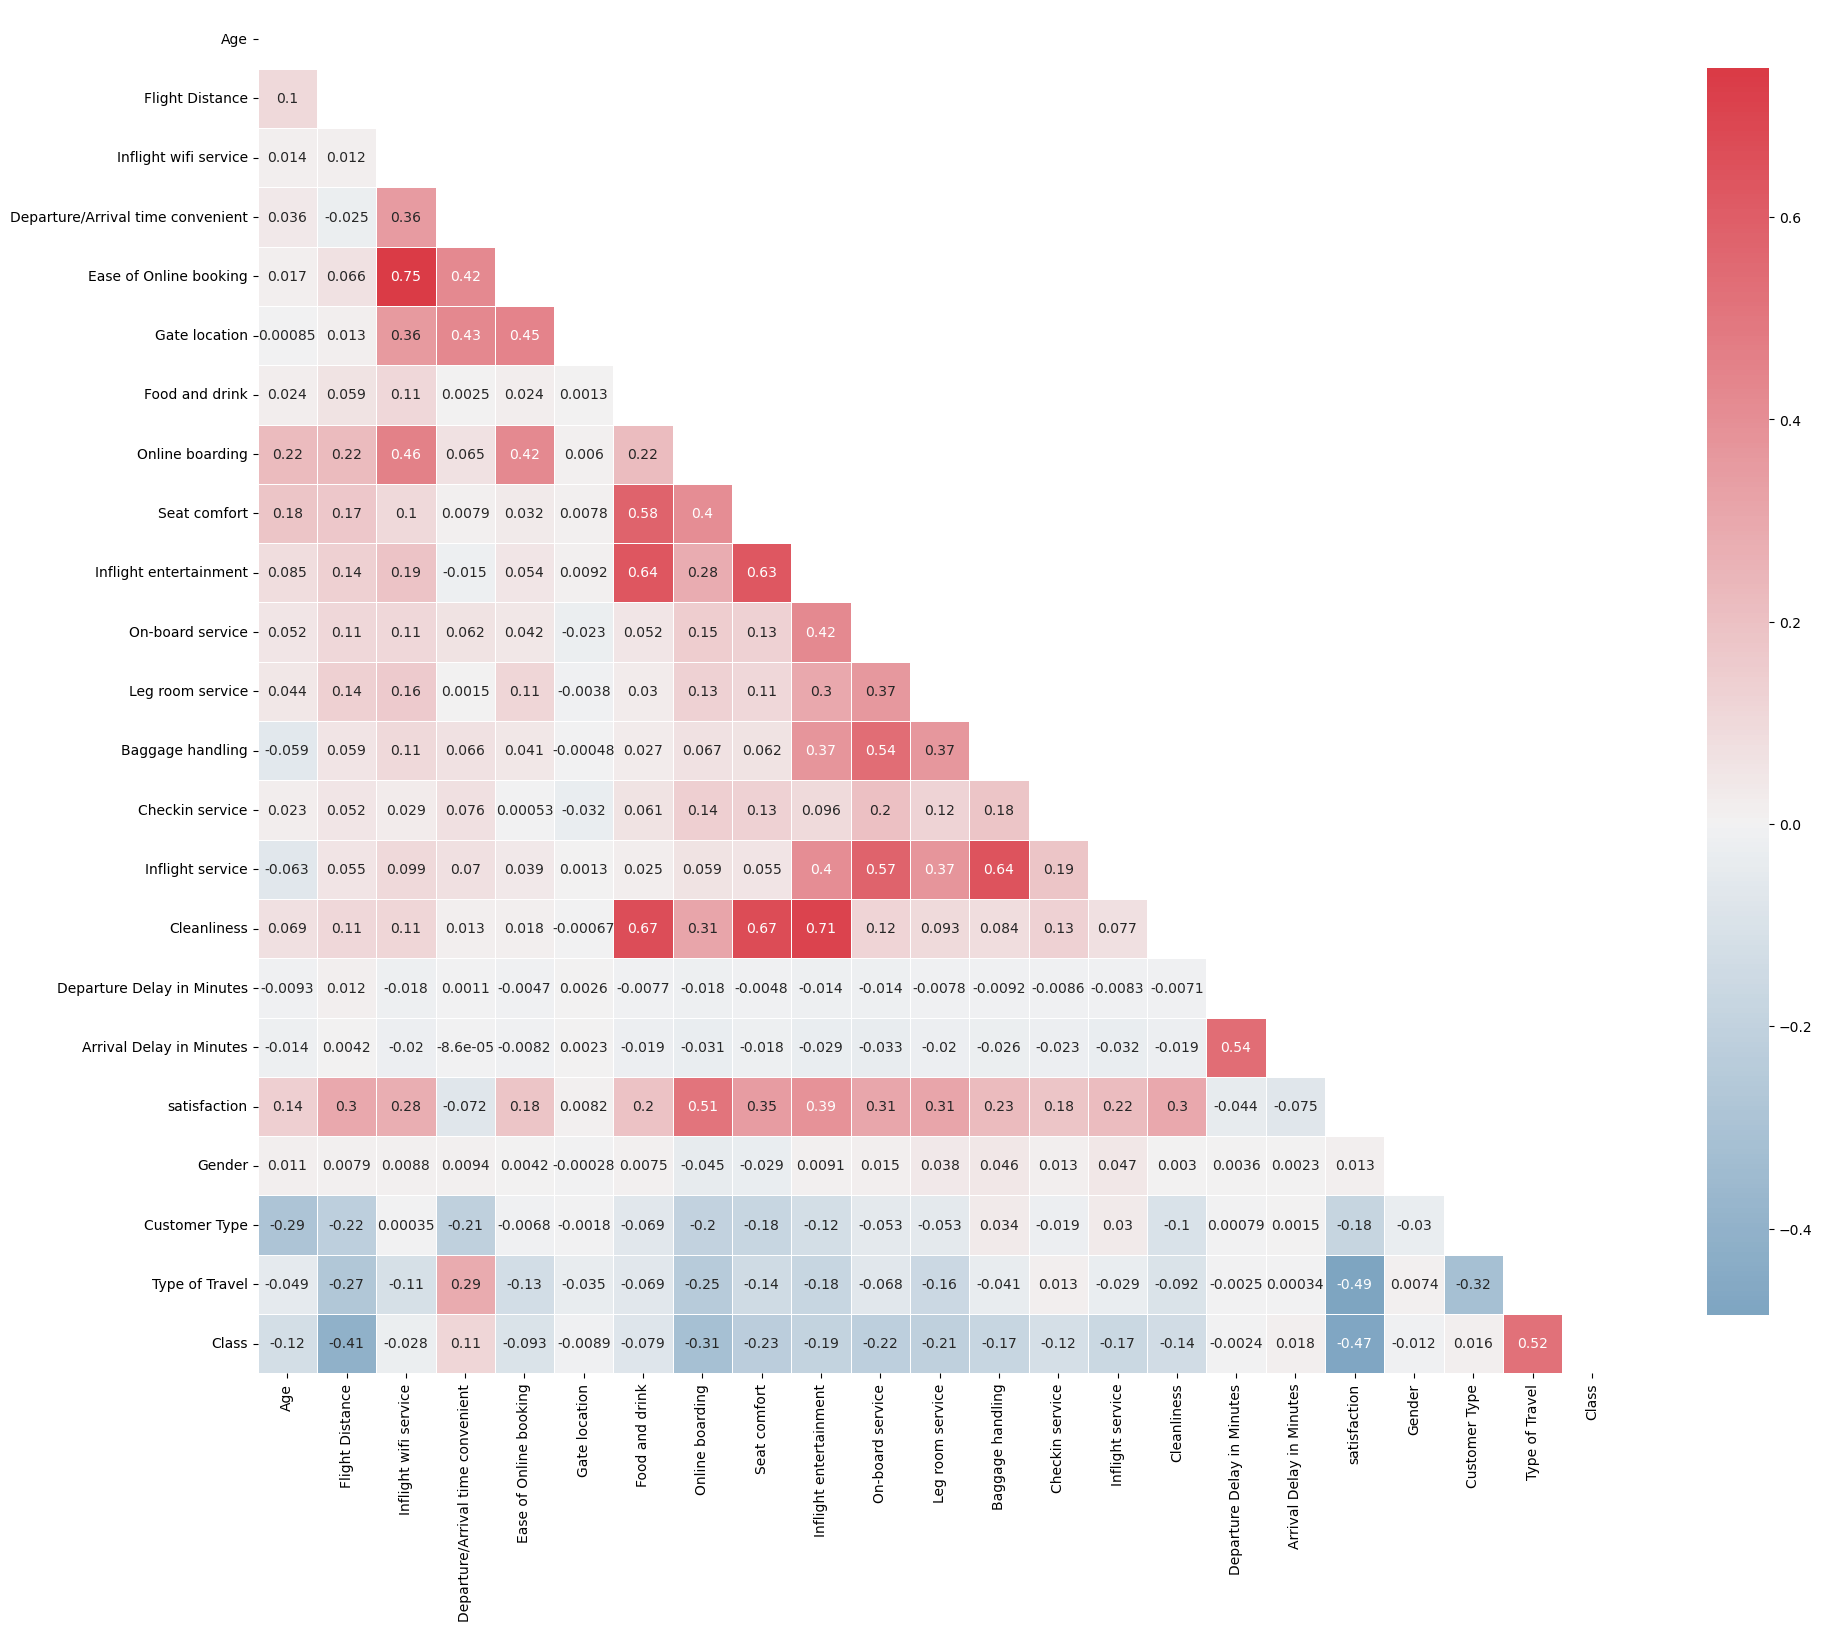

In [34]:
# Compute the correlation matrix
corr = filtered_df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

plt.show()

### Feature selection using chi-square

In [35]:
input_cols = filtered_df.columns

# Create VectorAssembler
assembler = VectorAssembler(inputCols=input_cols, outputCol="numerical_features")
scaler = MinMaxScaler(inputCol="numerical_features",
                      outputCol="scaled_features")

In [36]:
pipeline = Pipeline(stages=[assembler, scaler])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(filtered_df)

# Transform the data
scaled_df = pipeline_model.transform(filtered_df)

In [37]:
feature_columns = [col for col in scaled_df.columns if col != 'satisfaction']

# Step 4: Feature selection using ChiSqSelector
selector = ChiSqSelector(numTopFeatures=15, featuresCol="scaled_features", outputCol="selectedFeatures", labelCol="satisfaction")
selector_model = selector.fit(scaled_df)
selected_data = selector_model.transform(scaled_df)

# Step 5: Print and access selected feature names
selected_feature_indices = selector_model.selectedFeatures
selected_feature_names = [feature_columns[idx] for idx in selected_feature_indices]

print("Selected features:", selected_feature_names)




Selected features: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service']


In [38]:
selected_features = [
    'Age', 'Flight Distance', 'Inflight wifi service',
    'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Type of Travel', 'satisfaction'
]

# Select the specified columns from the existing DataFrame
train_data = train_df.select(*selected_features)
test_data = test_df.select(*selected_features)

In [39]:
selected_categorical_columns = [col for col,type in train_data.dtypes if type=='string' ]
selected_numerical_columns = [col for col,type in train_data.dtypes if type == 'int'and col!='satisfaction']
selected_test_categorical_columns = [col for col,type in test_data.dtypes if type=='string']
selected_test_numerical_columns = [col for col,type in test_data.dtypes if type == 'int'and col!='satisfaction']

print("categorical feature in train dataframe:",selected_categorical_columns)
print("numerical feature in train dataframe:",selected_numerical_columns)
print("categorical feature in test dataframe:",selected_test_categorical_columns)
print("numerical feature in test dataframe:",selected_test_numerical_columns)

categorical feature in train dataframe: ['Type of Travel']
numerical feature in train dataframe: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service']
categorical feature in test dataframe: ['Type of Travel']
numerical feature in test dataframe: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service']


## Building model

In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
indexers = []
encoders = []
encoded_feature_cols = []

# Create indexers and encoders for each categorical feature
for feature in selected_categorical_columns:
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_index")
    encoder = OneHotEncoder(inputCol=f"{feature}_index", outputCol=f"{feature}_ohe")
    indexers.append(indexer)
    encoders.append(encoder)
    encoded_feature_cols.append(f"{feature}_ohe")


In [41]:
encoded_feature_cols.extend(selected_numerical_columns)
encoded_feature_cols

['Type of Travel_ohe',
 'Age',
 'Flight Distance',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service']

In [42]:

from pyspark.ml.feature import MinMaxScaler
# input_cols = df.columns

# Create VectorAssembler
assembler = VectorAssembler(inputCols=encoded_feature_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features",
                      outputCol="scaledFeatures")

In [43]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
lr = LogisticRegression(featuresCol = "features",labelCol = "satisfaction",rawPredictionCol="rawPrediction")
rf = RandomForestClassifier(featuresCol="features",labelCol = "satisfaction",rawPredictionCol="rawPrediction")
nb = NaiveBayes(featuresCol="features",labelCol = "satisfaction",rawPredictionCol="rawPrediction")
gb = GBTClassifier(featuresCol="features",labelCol = "satisfaction")

In [44]:
models = [lr,rf,nb,gb]
model_names = ['Logistic Regression','Random Forest','Naive Bayes','Gradient boost']

In [45]:
def plot_roc_curve(predictions, model_name):
    # Extract the probability and label columns
    prediction_pdf = predictions.select("probability",
                                        "satisfaction").toPandas()
    prediction_pdf['probability'] = prediction_pdf['probability'].apply(
        lambda x: x[1])

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(prediction_pdf['satisfaction'],
                            prediction_pdf['probability'])
    roc_auc = auc(fpr, tpr)

    # Plotting using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=fpr,
                 y=tpr,
                 lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} roc_auc curve')
    plt.legend(loc="lower right")
    plt.show()


def get_best_model(models, model_names, train_data, test_data):
    best_model = None
    best_model_name = None
    best_roc_auc = 0.0

    # Evaluators for additional metrics
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol='satisfaction',
        predictionCol='prediction',
        metricName='accuracy')
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol='satisfaction', predictionCol='prediction', metricName='f1')
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol='satisfaction',
        predictionCol='prediction',
        metricName='weightedPrecision')
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol='satisfaction',
        predictionCol='prediction',
        metricName='weightedRecall')
    rmse_evaluator = RegressionEvaluator(labelCol='satisfaction',
                                         predictionCol='prediction',
                                         metricName='rmse')
    evaluator = BinaryClassificationEvaluator(labelCol='satisfaction',
                                              rawPredictionCol='rawPrediction',
                                              metricName='areaUnderROC')

    # DataFrame to store results
    results = pd.DataFrame(columns=[
        'Model', 'ROC-AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall'
        
    ])

    for model, model_name in zip(models, model_names):
        pipeline = Pipeline(stages=indexers + encoders +
                            [assembler, scaler, model])
        pipeline_model = pipeline.fit(train_data)
        predictions = pipeline_model.transform(test_data)

        # Evaluate metrics
        roc_auc = evaluator.evaluate(predictions)
        accuracy = accuracy_evaluator.evaluate(predictions)
        f1_score = f1_evaluator.evaluate(predictions)
        precision = precision_evaluator.evaluate(predictions)
        recall = recall_evaluator.evaluate(predictions)
        rmse = rmse_evaluator.evaluate(predictions)

        print(f"Metrics for {model_name}:")
        print(f"ROC-AUC: {roc_auc}")
        print(f"Accuracy: {accuracy}")
        print(f"F1-Score: {f1_score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        

        # Add results to the DataFrame
        new_row = pd.DataFrame({
            'Model': [model_name],
            'ROC-AUC': [roc_auc],
            'Accuracy': [accuracy],
            'F1-Score': [f1_score],
            'Precision': [precision],
            'Recall': [recall]
        })
        results = pd.concat([results, new_row], ignore_index=True)

        # Plot ROC curve
        plot_roc_curve(predictions, model_name)

        if roc_auc > best_roc_auc:
            best_model = pipeline_model
            best_model_name = model_name
            best_roc_auc = roc_auc

    print(f"Best model: {best_model_name} with ROC-AUC: {best_roc_auc}")

    # Save the results DataFrame to a CSV file
    results.to_csv('model_metrics.csv', index=False)

    return best_model, best_model_name, results

Metrics for Logistic Regression:
ROC-AUC: 0.9125269107132178
Accuracy: 0.853557129658146
F1-Score: 0.8533102926651801
Precision: 0.8533264754901664
Recall: 0.853557129658146


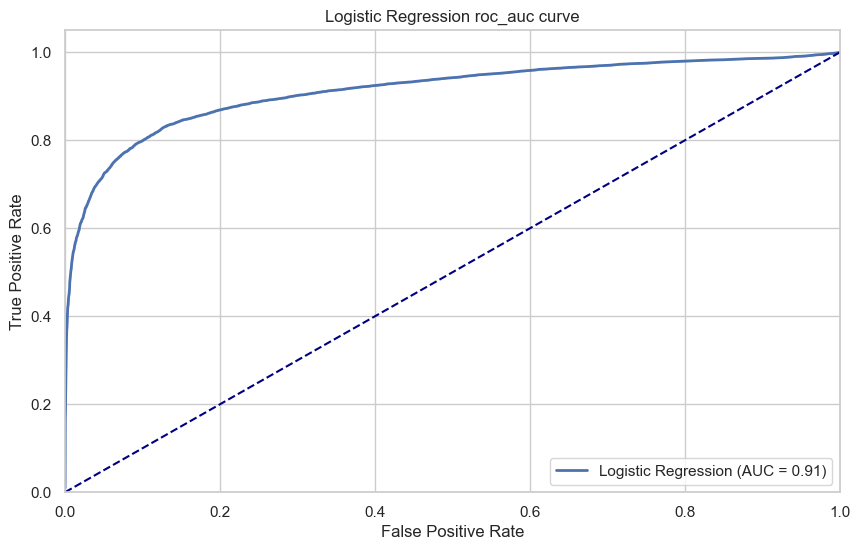

Metrics for Random Forest:
ROC-AUC: 0.9649954606238706
Accuracy: 0.9176932553125963
F1-Score: 0.9176451581629499
Precision: 0.9176354834996359
Recall: 0.9176932553125963


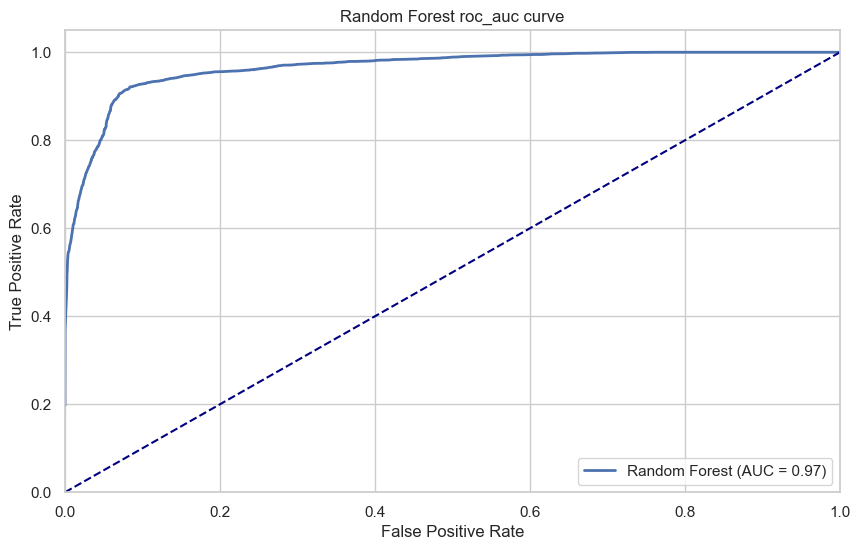

Metrics for Naive Bayes:
ROC-AUC: 0.22673711225270876
Accuracy: 0.6223821989528796
F1-Score: 0.6192934855152538
Precision: 0.6189723967338512
Recall: 0.6223821989528796


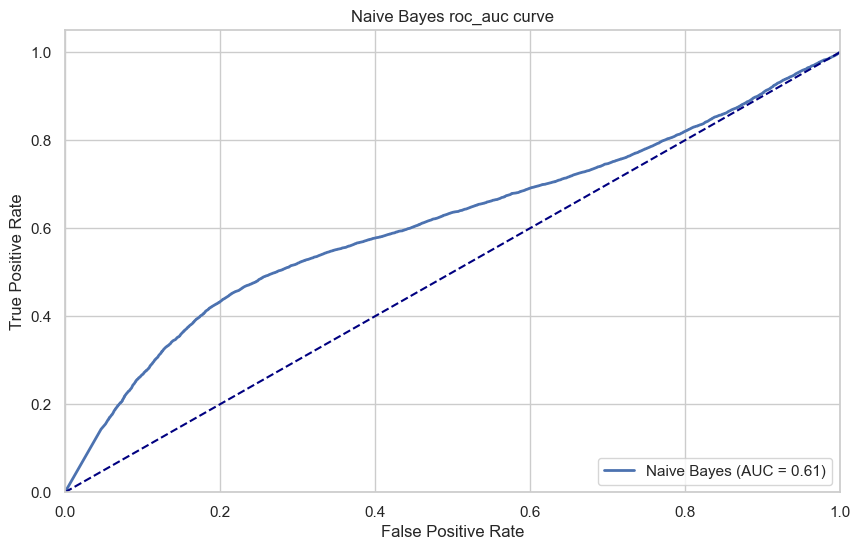

Metrics for Gradient boost:
ROC-AUC: 0.9805509124339489
Accuracy: 0.9292808746535264
F1-Score: 0.9291718022733586
Precision: 0.9293068605802084
Recall: 0.9292808746535264


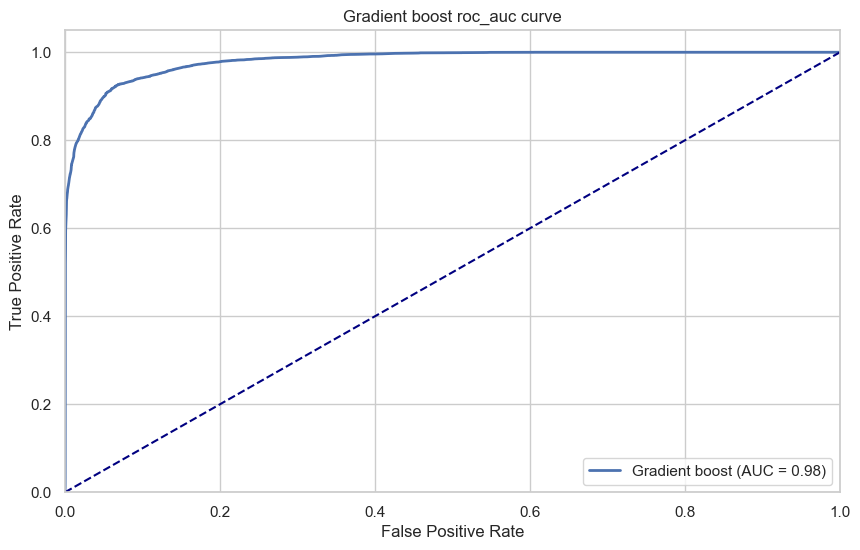

Best model: Gradient boost with ROC-AUC: 0.9805509124339489


In [46]:
best_model, best_model_name, results = get_best_model(models, model_names, train_data, test_data)


In [47]:
result = pd.read_csv("model_metrics.csv")

In [48]:
result

,Model,ROC-AUC,Accuracy,F1-Score,Precision,Recall
0,Logistic Regression,0.912527,0.853557,0.853310,0.853326,0.853557
1,Random Forest,0.964995,0.917693,0.917645,0.917635,0.917693
2,Naive Bayes,0.226737,0.622382,0.619293,0.618972,0.622382
3,Gradient boost,0.980551,0.929281,0.929172,0.929307,0.929281
